# Лабораторная работа №4. Оценка важности признаков и визуализация в глубоком обучении
Пан Анатолий Эдуардович<br>
Группа 932209<br>


## Подключаем Google Drive

In [1]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Change directory
import os
os.chdir("/content/drive/MyDrive/masters/DL/labs")

## Полносвзяная модель (классификация)

### Здесь была классификация больных диабетом из лабораторной работы 1. Проделаем те же самые шаги

In [3]:
from zipfile import ZipFile
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.optimizers import Adam
from keras.metrics import Recall, Precision, AUC, Accuracy
from keras.utils import plot_model, to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
df.head()

Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0.0   9.0        4.0   
1          1.0      3.0       0.0       0.0       0.0  0.0   7.0        6.0   
2          1.0      5.0      30.0      30.0       1.0  0.0   9.0        4.0   
3          0.0      2.0       0.0       0.0       0.0  0.0  11.0        3.0   
4          0.0      2.0       3.0       0.0       0.0  0.0  11.0        5.0   

   Income  
0     3.0  
1     1.0  
2     8.0  
3     6.0  
4     4.0  

[5 rows x 22 columns]

In [5]:
# Drop duplicates
df.drop_duplicates(inplace=True)
df.shape

(229781, 22)

In [6]:
df[df["Diabetes_012"]==2] = 1.0

In [7]:
df["Diabetes_012"].value_counts()

0.0    190055
1.0     39726
Name: Diabetes_012, dtype: int64

In [8]:
df["Diabetes"] = df["Diabetes_012"]
df.drop(columns = "Diabetes_012", inplace=True)

In [9]:
df = df.astype('int32')

In [10]:
majority_class = df[df['Diabetes'] == 0]
minority_class = df[df['Diabetes'] == 1]

In [11]:
majority_class_downsampled = resample(majority_class,
                                      replace=False,
                                      n_samples=len(minority_class),
                                      random_state=42)

In [12]:
df_resampled = pd.concat([majority_class_downsampled, minority_class])

In [13]:
df = df_resampled

In [14]:
df.shape

(79452, 22)

In [15]:
# Target dataframe
X = df.drop('Diabetes', axis=1)
y = df['Diabetes']

In [16]:
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [18]:
model = keras.Sequential([
    layers.Dense(8, activation="relu", input_dim=X_train.shape[1]),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])

In [19]:
model.compile(optimizer=Adam(0.00001),
              loss="binary_crossentropy",
              metrics=[Recall(),
                       Precision(),
                       "AUC",
                       "accuracy"])

In [20]:
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5,
                           mode='max',
                           verbose=1
                           )
checkpoint = ModelCheckpoint('diabet_binary.hdf5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True
                             )

callbacks_list=[early_stop, checkpoint]

In [21]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15,
                    batch_size=64,
                    callbacks=callbacks_list)

Epoch 1/15
864/869 [============================>.] - ETA: 0s - loss: 0.6833 - recall: 0.9718 - precision: 0.5594 - auc: 0.7632 - accuracy: 0.6030
Epoch 1: val_accuracy improved from -inf to 0.63819, saving model to diabet_binary.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


869/869 [==============================] - 9s 6ms/step - loss: 0.6832 - recall: 0.9717 - precision: 0.5594 - auc: 0.7633 - accuracy: 0.6032 - val_loss: 0.6783 - val_recall: 0.9624 - val_precision: 0.5838 - val_auc: 0.7915 - val_accuracy: 0.6382
Epoch 2/15
857/869 [============================>.] - ETA: 0s - loss: 0.6733 - recall: 0.9523 - precision: 0.6123 - auc: 0.8038 - accuracy: 0.6749
Epoch 2: val_accuracy improved from 0.63819 to 0.73418, saving model to diabet_binary.hdf5
869/869 [==============================] - 4s 5ms/step - loss: 0.6732 - recall: 0.9519 - precision: 0.6132 - auc: 0.8039 - accuracy: 0.6757 - val_loss: 0.6649 - val_recall: 0.9440 - val_precision: 0.6650 - val_auc: 0.8319 - val_accuracy: 0.7342
Epoch 3/15
855/869 [============================>.] - ETA: 0s - loss: 0.6569 - recall: 0.9284 - precision: 0.7128 - auc: 0.8625 - accuracy: 0.7772
Epoch 3: val_accuracy improved from 0.73418 to 0.82103, saving model to diabet_binary.hdf5
869/869 [=========================

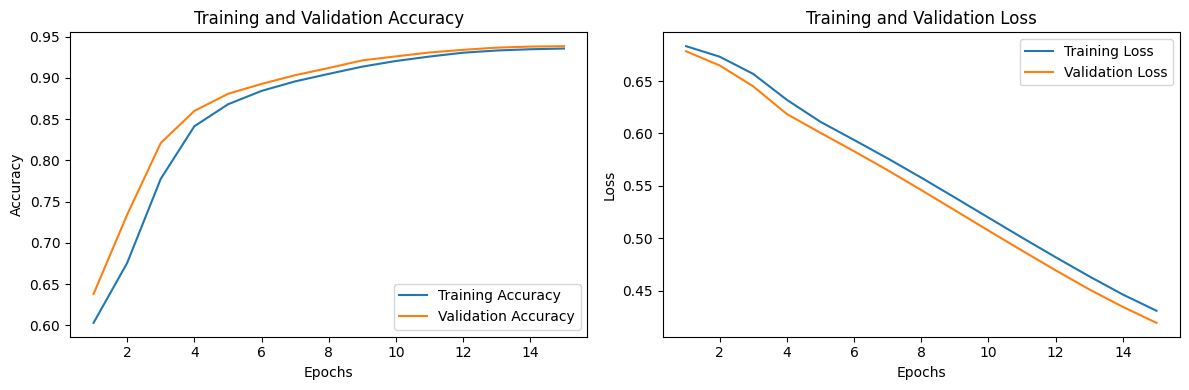

In [22]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
model.load_weights("diabet_binary.hdf5")

In [24]:
results = model.evaluate(X_test, y_test)

373/373 [==============================] - 1s 3ms/step - loss: 0.4214 - recall: 0.8899 - precision: 0.9846 - auc: 0.9429 - accuracy: 0.9380


In [25]:
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

373/373 [==============================] - 1s 2ms/step


### Начнем оценку признаков


Импортируем необходимый модуль

In [26]:
!pip install shap -q

In [27]:
import shap
from keras.models import load_model

Загрузка лучшей модели

In [28]:
best_model = load_model("diabet_binary.hdf5")

SHAP explaner

In [42]:
background_samples = shap.sample(X_train, 20)
# explainer = shap.DeepExplainer(best_model, background_samples)
explainer = shap.KernelExplainer(best_model.predict, background_samples)

1/1 [==============================] - 0s 39ms/step


In [43]:
explainer_2 = shap.Explainer(best_model, background_samples)

In [44]:
# SHAP values
sample_indices = np.random.choice(X_val.shape[0], size=200, replace=False)  # Выберите подходящий размер
X_val_subset = X_val[sample_indices, :]

In [45]:
shap_values_subset = explainer.shap_values(X_val_subset)

  0%|          | 0/200 [00:00<?, ?it/s]

1305/1305 [==============================] - 2s 2ms/step


In [46]:
shap_values = explainer_2.shap_values(X_val_subset)

In [47]:
feature_names = df.columns.drop('Diabetes').tolist()

Оценка важности признаков

In [48]:
importance = np.mean(np.abs(shap_values), axis=0)

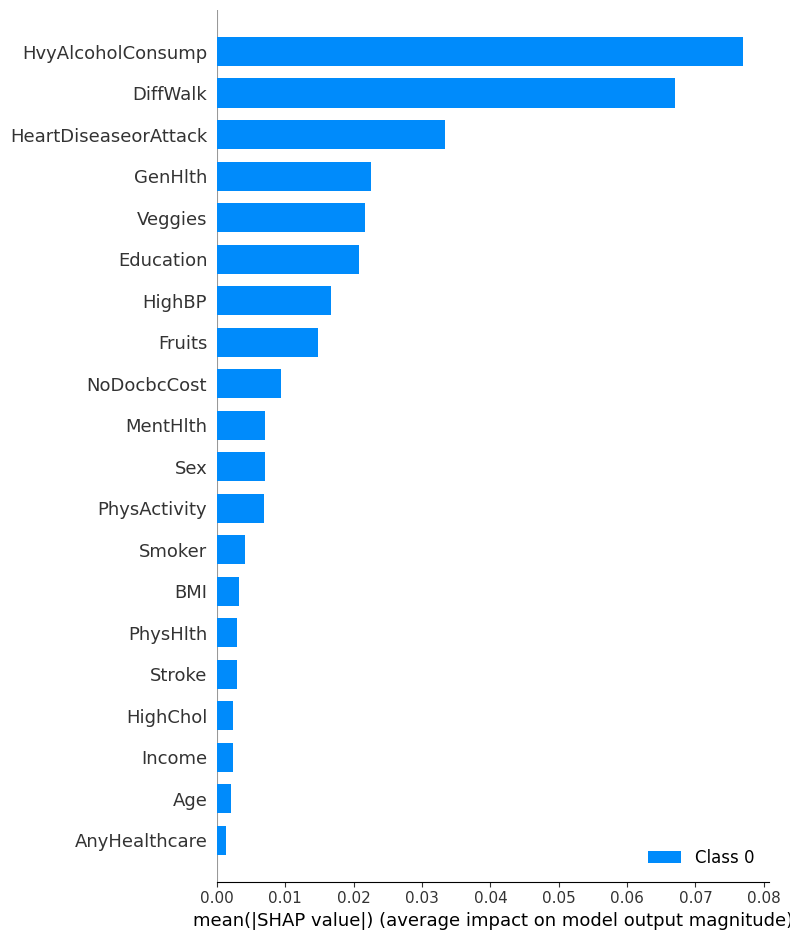

In [49]:
# Визуализация значений Шепли для набора данных
shap.summary_plot(shap_values_subset, X_val_subset, feature_names=feature_names)

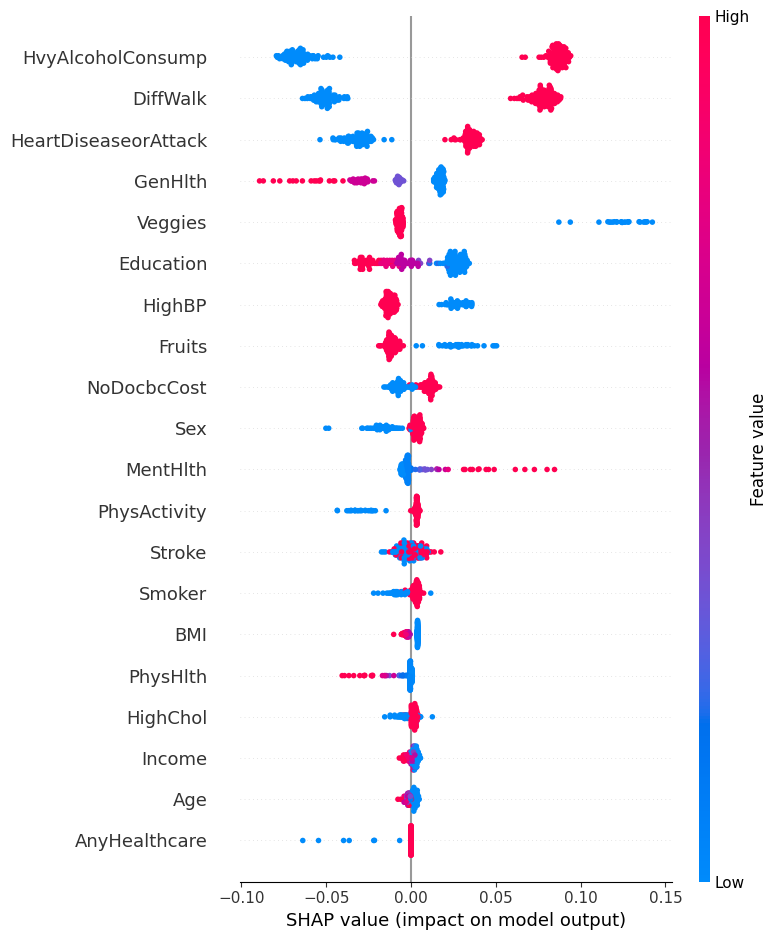

In [50]:
shap.summary_plot(shap_values, X_val_subset, feature_names=feature_names)

Визуализация наиболее важных зависимостей

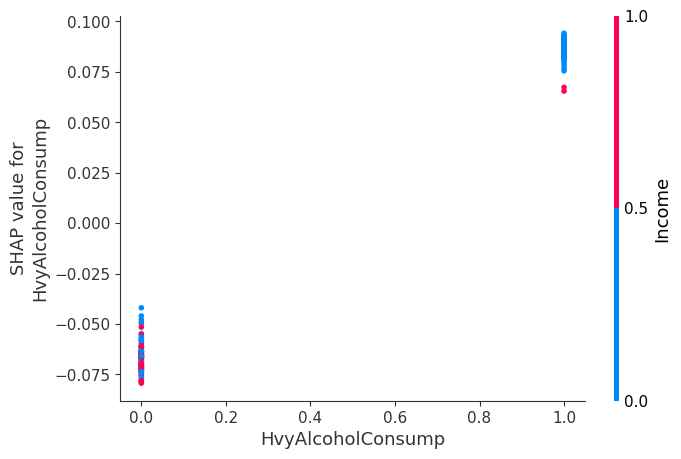

In [51]:
shap.dependence_plot("HvyAlcoholConsump", shap_values, X_val_subset, feature_names=feature_names)

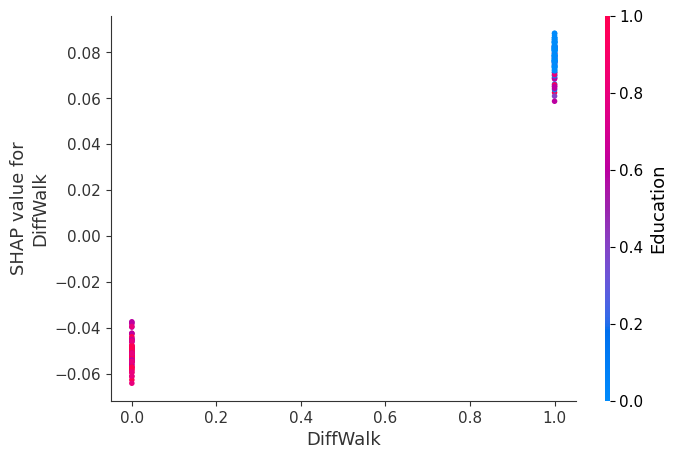

In [53]:
shap.dependence_plot("DiffWalk", shap_values, X_val_subset, feature_names=feature_names)

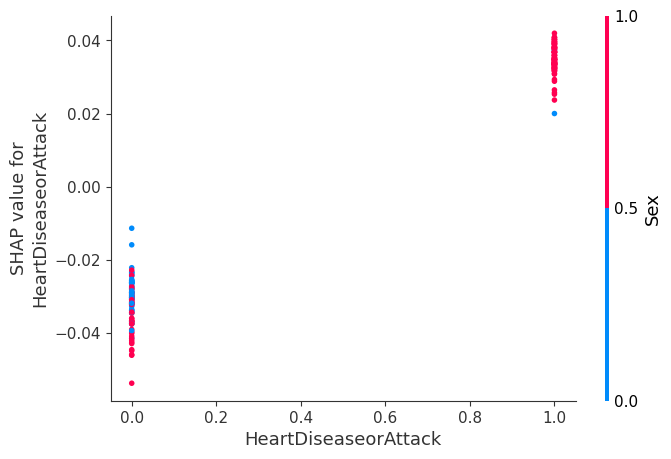

In [56]:
shap.dependence_plot("HeartDiseaseorAttack", shap_values, X_val_subset, feature_names=feature_names)

Выбор ряда примеров для объяснений

In [63]:
sample_indices_class_0 = np.where(y_val == 0)[0][:2]
sample_indices_class_1 = np.where(y_val == 1)[0][:2]

In [64]:
feature_names = [str(i) for i in range(X_val_subset.shape[1])]

In [65]:
shap_values_for_wt = explainer_2(X_val_subset)

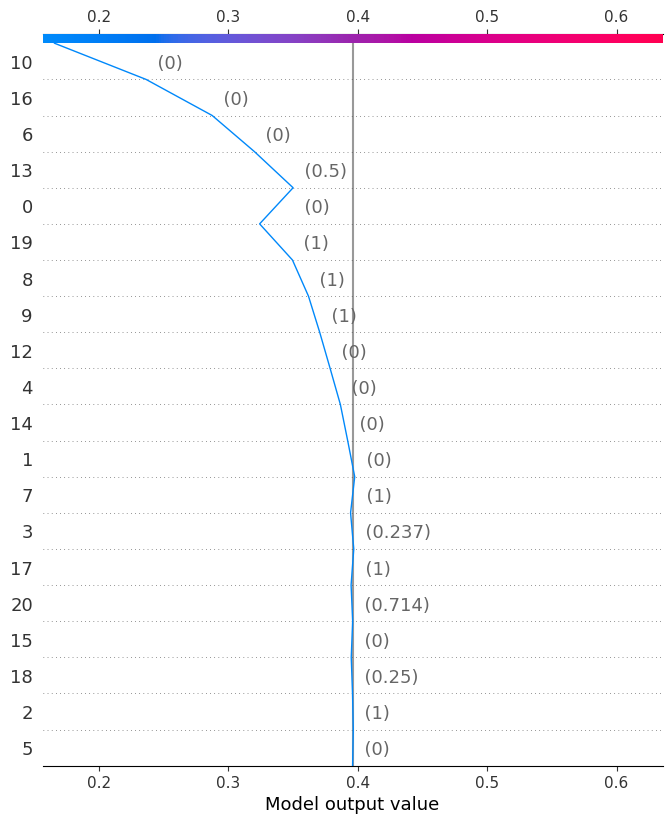

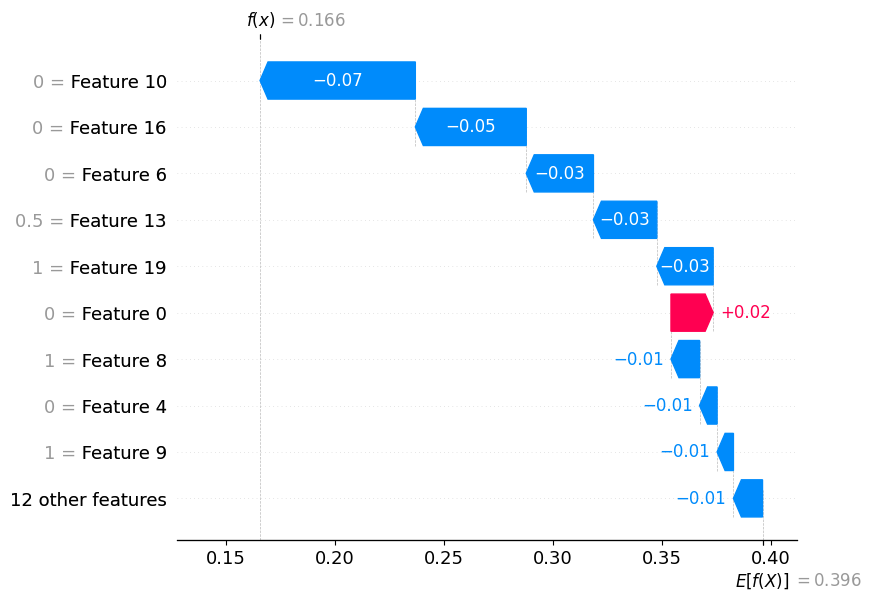

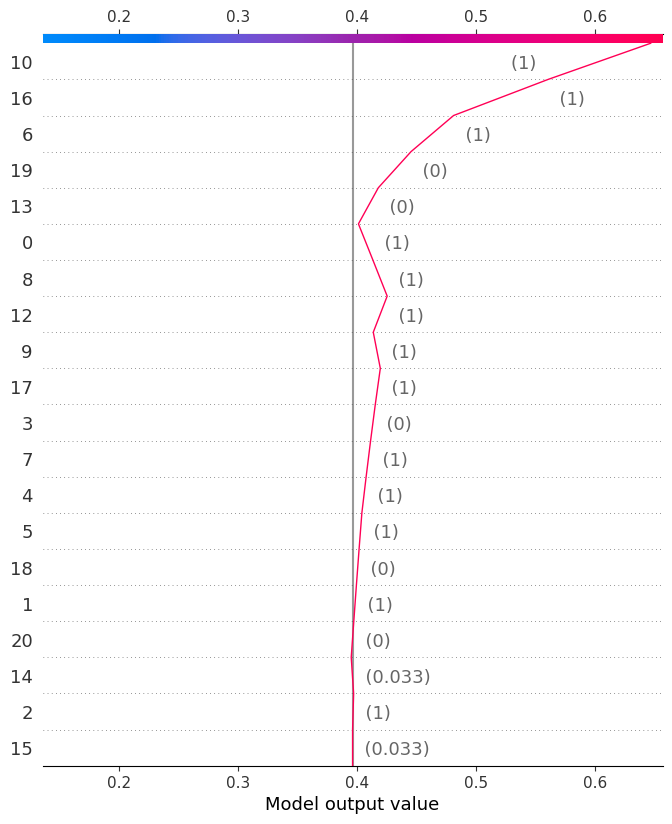

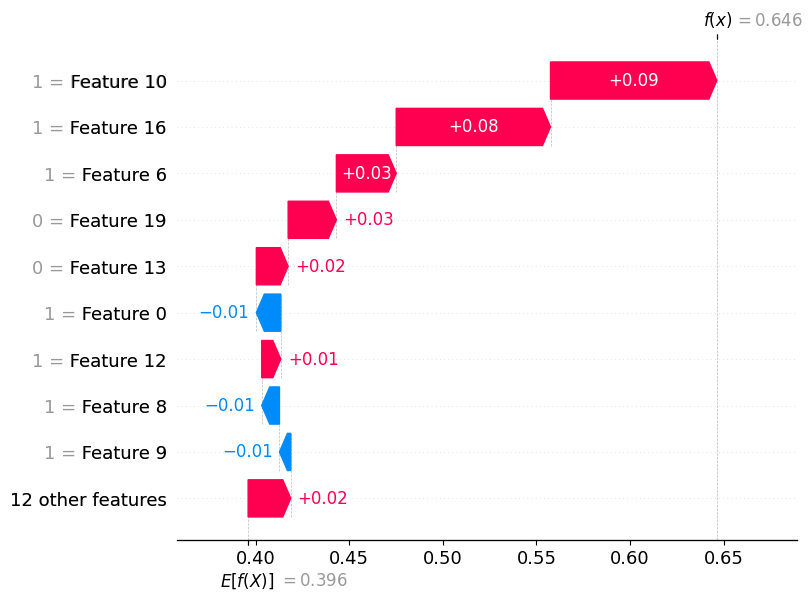

In [66]:
for index in sample_indices_class_0:
    shap.decision_plot(explainer.expected_value, shap_values_subset[0][index, :], X_val_subset[index, :], feature_names=feature_names)
    shap.force_plot(explainer.expected_value, shap_values_subset[0][index, :], X_val_subset[index, :], feature_names=feature_names)
    shap.waterfall_plot(shap_values_for_wt[index])

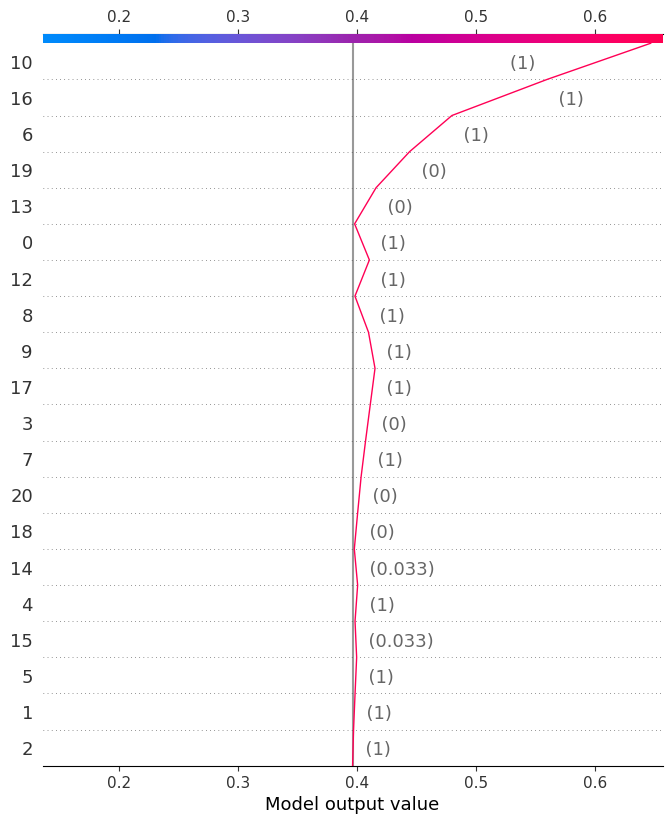

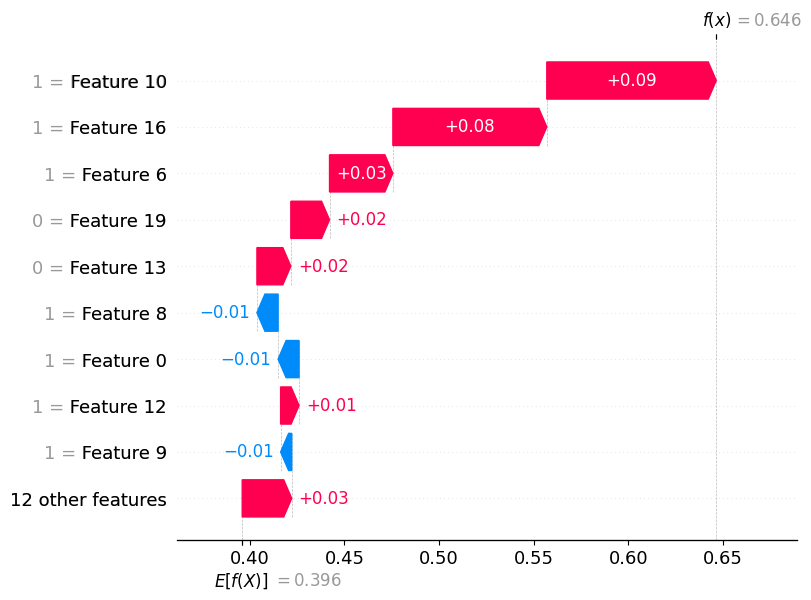

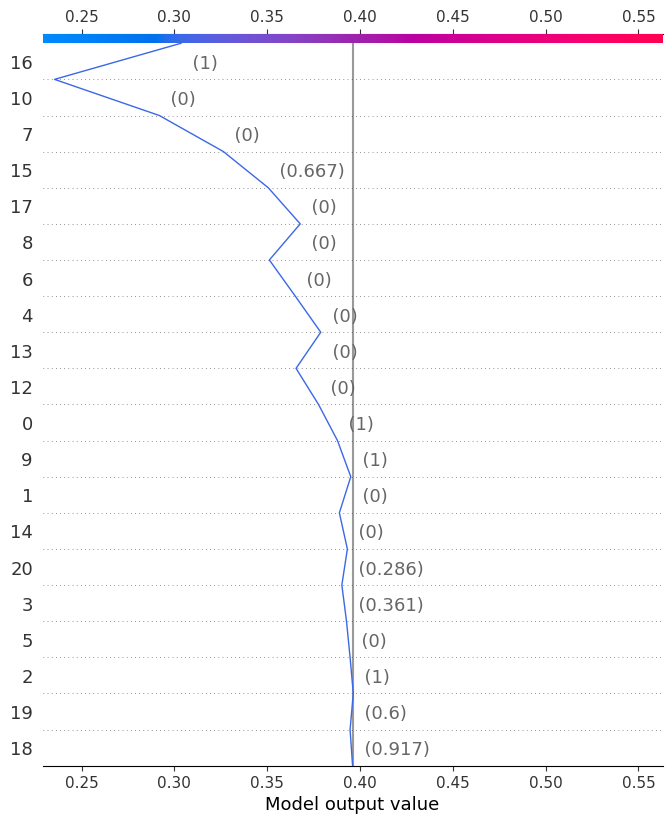

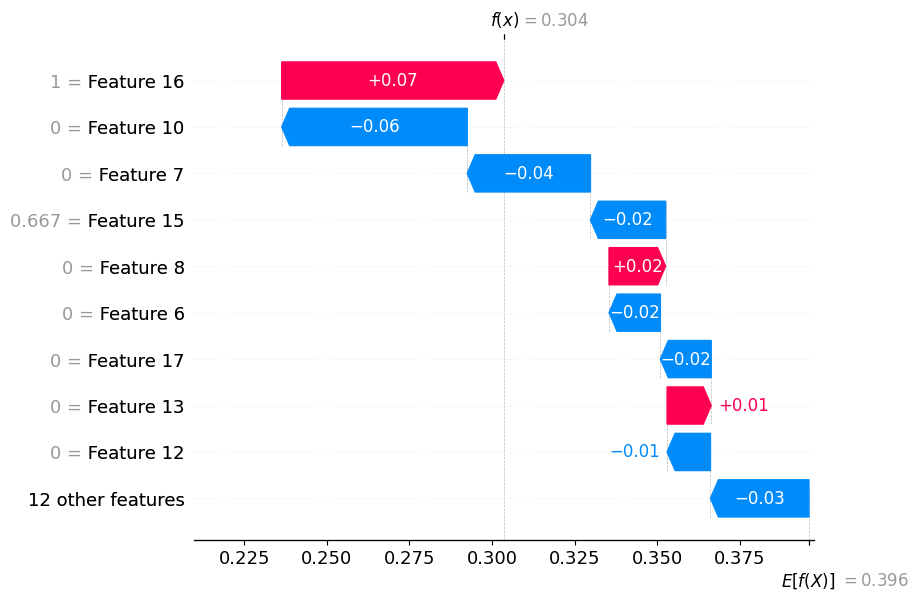

In [67]:
for index in sample_indices_class_1:
    shap.decision_plot(explainer.expected_value, shap_values_subset[0][index, :], X_val_subset[index, :], feature_names=feature_names)
    shap.force_plot(explainer.expected_value, shap_values_subset[0][index, :], X_val_subset[index, :], feature_names=feature_names)
    shap.waterfall_plot(shap_values_for_wt[index])

## Нейросетевой регрессор


### Запустим код с прошлого задания

In [68]:
df = pd.read_csv("/content/drive/MyDrive/masters/DL/labs/DS_2019_public.csv", encoding="latin-1")
df.head()

Columns (30,56,96,114) have mixed types. Specify dtype option on import or set low_memory=False.


Climate_Region_Pub  DIVISION  REPORTABLE_DOMAIN DOLELCOL  TOTALDOLCOL  \
0                   5        10                 26   16.793           17   
1                   1         1                  1   48.901           49   
2                   1         3                  7  101.048          101   
3                   1         1                  1        0            0   
4                   1         4                 10   45.132           45   

     KWHCOL  BTUELCOL  TOTALBTUCOL  TOTALDOLSPH  TOTALBTUSPH  ...  LGT1EE  \
0   181.998   620.979          621          368        38606  ...      -2   
1   184.459   629.389          629          582        40248  ...       2   
2  1063.022  3627.013         3627          425        40196  ...      -2   
3     0.000     0.000            0          616        36136  ...       2   
4   274.530   936.677          937          685        74100  ...       3   

   TOTALBTUWTH  ROOFTYPE  DOLELRFG  TOTALDOLRFG  HEATROOM  WDWATER  UGWARM  \
0        30110         2   120.893          121         4        0       1   
1         7933        -2   242.746          243         2        0       1   
2         6440         5   158.797          159         7        0       1   
3        13884         5    85.138           85         5        0       1   
4        14204         6   151.319          151         6        0       1   

   DRYRFUEL    KWHRFG  
0         1  1310.220  
1        -2   915.664  
2         5  1670.534  
3         5   346.468  
4         5   920.454  

[5 rows x 121 columns]

In [69]:
df.shape

(10875, 121)

Будем предсказывать `TOTALDOLWTH` (Total cost for water heating, in whole dollars)

#### Предобработка данных

Информация о датасете

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10875 entries, 0 to 10874
Columns: 121 entries, Climate_Region_Pub to KWHRFG
dtypes: float64(34), int64(79), object(8)
memory usage: 10.0+ MB


В наборе данных есть некоторые ошибки в данных. Вместо чисел записаны даты. Удалим эти столбцы. Для начала определим в каких столбцах встречаются такие записи

In [71]:
object_cols = list(df.dtypes[df.dtypes == 'object'].keys())
object_cols

['DOLELCOL',
 'DOLFOSPH',
 'DOLELSPH',
 'DOLNGWTH',
 'CUFEETNGOTH',
 'KWHOTH',
 'CUFEETNGWTH',
 'DOLELRFG']

In [72]:
df = df.drop(object_cols, axis=1)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10875 entries, 0 to 10874
Columns: 113 entries, Climate_Region_Pub to KWHRFG
dtypes: float64(34), int64(79)
memory usage: 9.4 MB


Выберем более 5 признаков для проведения предсказания нашего target. Для этого выберем не признаки, значения корреляции которых с target &ge; 0.4

In [74]:
# Построим корреляционную матрицу признаков
correlation_matrix = df.corr()

# Выберите корреляцию между целевым признаком и остальными признаками
correlation_with_target = correlation_matrix['TOTALDOLWTH'].sort_values(ascending=False)

# correlation_with_target теперь содержит корреляции с целевым признаком, упорядоченные по убыванию
feature_cols = list(correlation_with_target[:12].keys())

Получилось 11 таких признаков

In [75]:
correlation_with_target[:12]

TOTALDOLWTH    1.000000
TOTALBTUWTH    0.702407
TOTALDOL       0.615648
TOTALBTU       0.499288
DOLLAREL       0.497141
TOTALDOLOTH    0.459576
DOLELOTH       0.447901
KWH            0.435446
BTUEL          0.435446
BTUELOTH       0.415200
DOLELWTH       0.404145
TOTALBTUOTH    0.401453
Name: TOTALDOLWTH, dtype: float64

Оставим только эти 11 признаков + целевая переменная

In [76]:
df = df[feature_cols]

Посмотрим на выбросы в данных

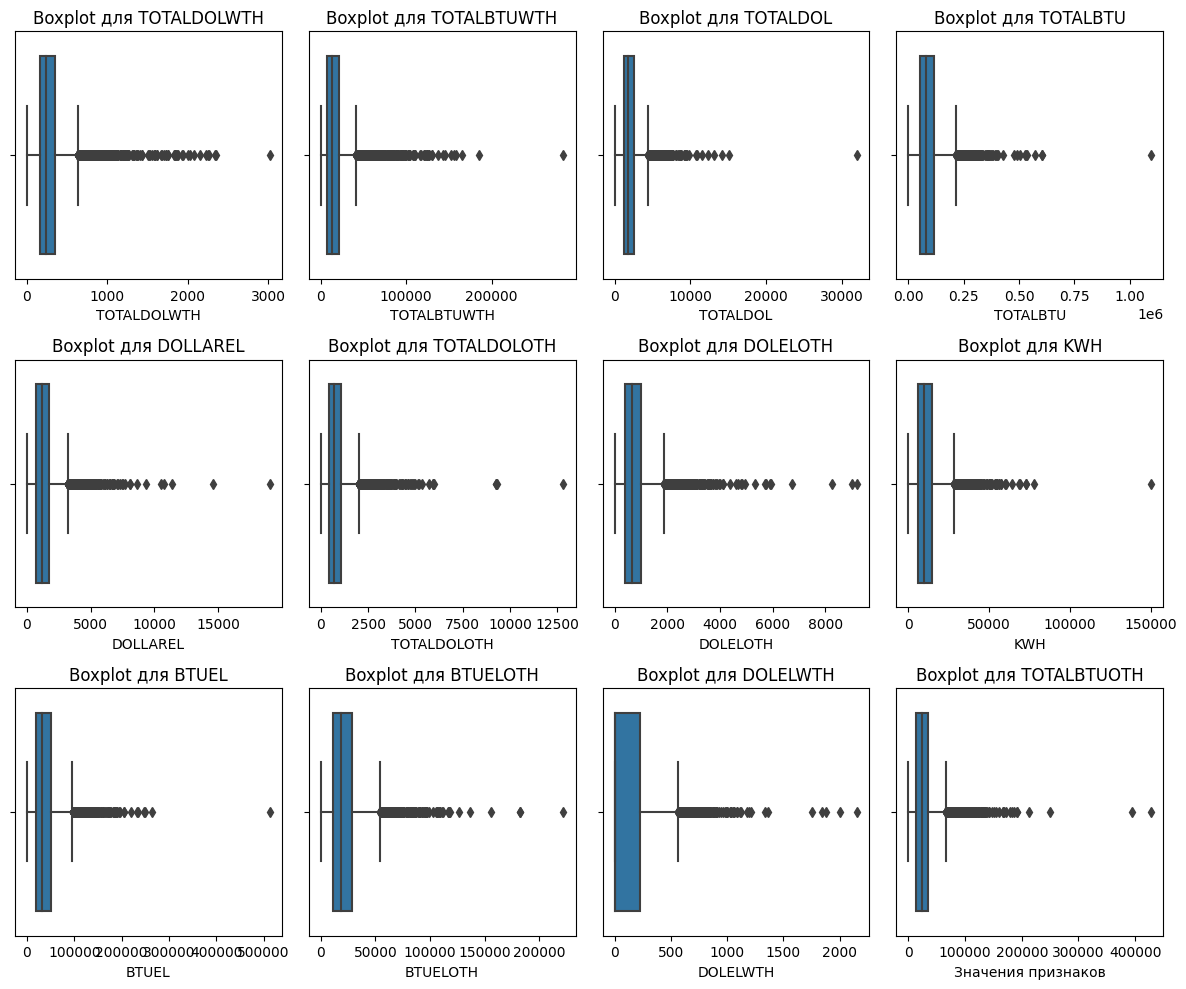

In [77]:
# Создайте фигуру и массив подграфиков
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 10))  # Измените размер по вашему усмотрению

# Создайте отдельный boxplot для каждого признака
for i, column in enumerate(df.columns):
    row = i // 4
    col = i % 4
    sns.boxplot(x=df[column], ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot для {column}')

# Настройте метки осей
plt.xlabel("Значения признаков")

# Регулируем расположение подграфиков
plt.tight_layout()

# Отображение графиков
plt.show()

Статистические данные датасета

In [78]:
df.describe()

TOTALDOLWTH    TOTALBTUWTH      TOTALDOL      TOTALBTU      DOLLAREL  \
count  10875.000000   10875.000000  10875.000000  1.087500e+04  10875.000000   
mean     281.556414   16313.564138   2040.286437  9.007189e+04   1353.120644   
std      196.000856   13733.416871   1184.555321  5.470184e+04    909.570610   
min        0.000000       0.000000      6.000000  5.800000e+01      0.000000   
25%      161.000000    7708.000000   1273.000000  5.158800e+04    739.000000   
50%      240.000000   12761.000000   1831.000000  8.063600e+04   1152.000000   
75%      350.000000   21169.500000   2543.500000  1.171230e+05   1729.000000   
max     3019.000000  284130.000000  32012.000000  1.096083e+06  19040.000000   

        TOTALDOLOTH      DOLELOTH            KWH          BTUEL  \
count  10875.000000  10875.000000   10875.000000   10875.000000   
mean     840.446069    767.469861   11296.214805   38542.686253   
std      609.765502    552.814641    7657.703365   26128.080323   
min        3.000000      0.000000      17.000000      58.000000   
25%      442.000000    396.676000    5866.000000   20014.500000   
50%      713.000000    649.216000    9615.000000   32806.000000   
75%     1069.500000    989.100500   14788.500000   50458.000000   
max    12826.000000   9213.064000  150254.000000  512667.000000   

            BTUELOTH      DOLELWTH    TOTALBTUOTH  
count   10875.000000  10875.000000   10875.000000  
mean    21500.232138    119.821407   26840.540506  
std     14727.448316    180.970339   19478.704624  
min        32.719000      0.000000      33.000000  
25%     10970.123500      0.000000   13935.000000  
50%     18521.083000      0.000000   22995.000000  
75%     28353.442500    225.700500   34853.000000  
max    221973.784000   2155.258000  428085.000000

In [79]:
X = df.drop("TOTALDOLWTH", axis=1)
y = df["TOTALDOLWTH"]

Применим масштабирование к признакам

In [80]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Разделяем на 3 выборки

In [81]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Получилась следующая модель

In [82]:
model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, 'linear')
])

Т.к. наблюдаются огромные выбросы, то используем Huber в качестве функции потерь.

Huber Loss является комбинацией MSE и MAE. Он менее чувствителен к выбросам, чем MSE, и менее чувствителен к малым ошибкам, чем MAE.

In [83]:
from tensorflow.keras.losses import Huber, LogCosh

Начнем обучение модели

In [84]:
model.compile(optimizer="adam", loss=Huber(), metrics=['mae'])

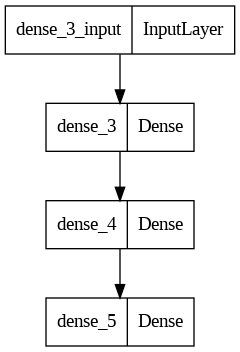

In [85]:
plot_model(model, to_file='NN_regression_model.png')

In [86]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
272/272 [==============================] - 3s 4ms/step - loss: 266.9749 - mae: 267.4747 - val_loss: 217.7273 - val_mae: 218.2258
Epoch 2/100
272/272 [==============================] - 1s 4ms/step - loss: 167.8326 - mae: 168.3321 - val_loss: 139.7205 - val_mae: 140.2201
Epoch 3/100
272/272 [==============================] - 1s 5ms/step - loss: 125.7617 - mae: 126.2610 - val_loss: 99.9375 - val_mae: 100.4364
Epoch 4/100
272/272 [==============================] - 1s 5ms/step - loss: 73.7288 - mae: 74.2270 - val_loss: 44.8105 - val_mae: 45.3059
Epoch 5/100
272/272 [==============================] - 1s 5ms/step - loss: 41.8639 - mae: 42.3588 - val_loss: 32.6373 - val_mae: 33.1313
Epoch 6/100
272/272 [==============================] - 1s 4ms/step - loss: 35.3660 - mae: 35.8586 - val_loss: 28.9253 - val_mae: 29.4140
Epoch 7/100
272/272 [==============================] - 1s 3ms/step - loss: 32.5940 - mae: 33.0819 - val_loss: 27.1383 - val_mae: 27.6221
Epoch 8/100
272/272 [=========

Построим графики зависимости потерь и средней абсолютной ошибки от количества эпох

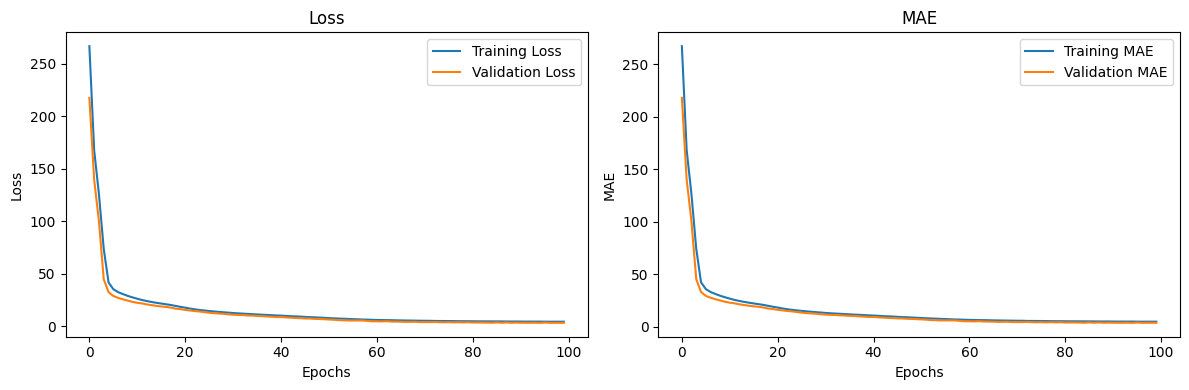

In [87]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

Выполним предсказание на тестовой выборке и построим линию регрессии

34/34 [==============================] - 0s 1ms/step


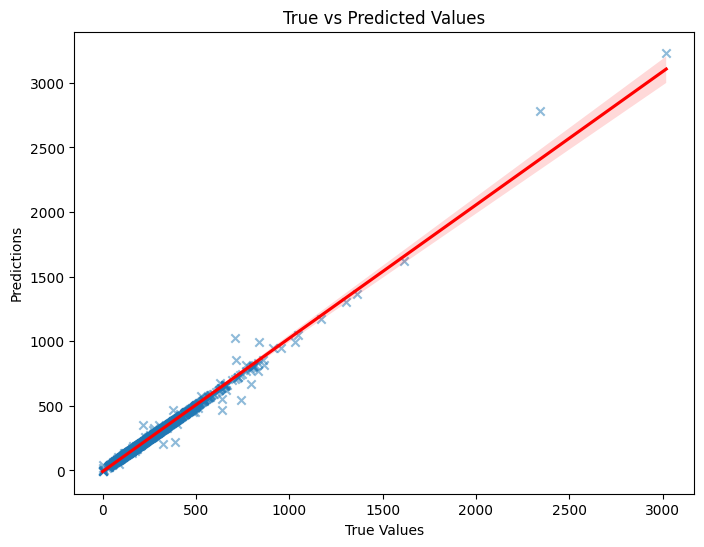

In [88]:
# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# График с линией регрессии
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5}, marker="x", line_kws=dict(color="r"))
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

Оценка модели на тестовой выборке (метрики)

In [89]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [90]:
print(f"mse:\t{mse}\nmae:\t{mae}\nr2:\t{r2}")

mse:	530.1425870101074
mae:	4.4145046862609245
r2:	0.9872112612613786


#### Начинаем оценку важности признаков

Создаем объект SHAP Explainer

In [91]:
!pip install shap -q

In [92]:
import shap

In [93]:
explainer = shap.Explainer(model, X_train)

Получаем SHAP значений для тестовых данных

In [94]:
shap_values = explainer.shap_values(X_test)

PermutationExplainer explainer: 1089it [00:29, 19.14it/s]                          


Визуализация summary plot значений Шепли

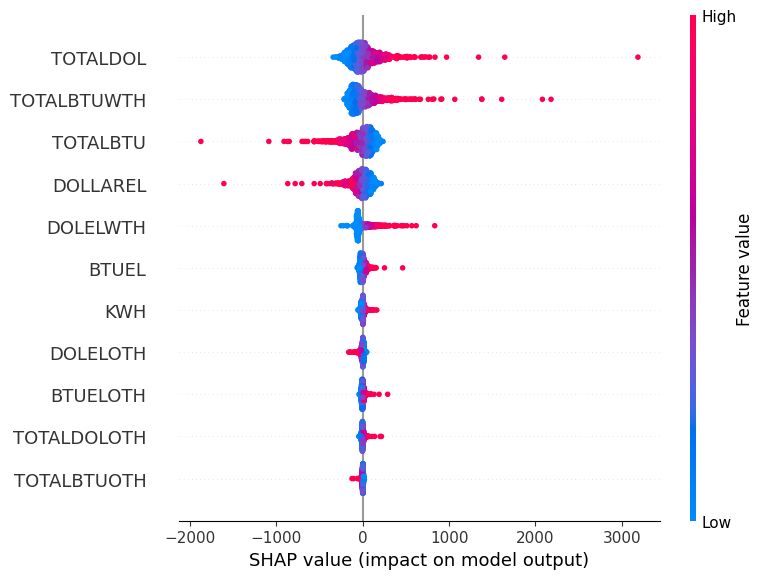

In [95]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

Получение важности признаков

In [96]:
feature_importance = np.abs(shap_values).mean(axis=0)

In [97]:
feature_importance

array([122.7416189 , 123.7039936 , 109.95947312,  75.40682759,
        10.2105654 ,  13.09711634,  14.33839824,  23.79358387,
        11.25552497,  73.28448223,   5.29140835])

Визуализация dependence plot для наиболее важных признаков

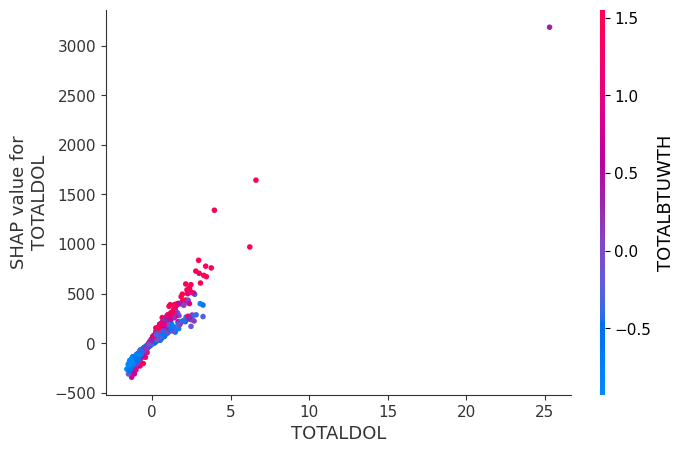

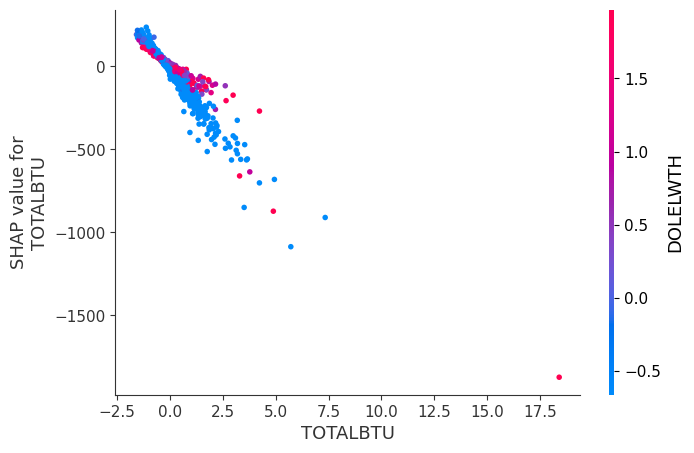

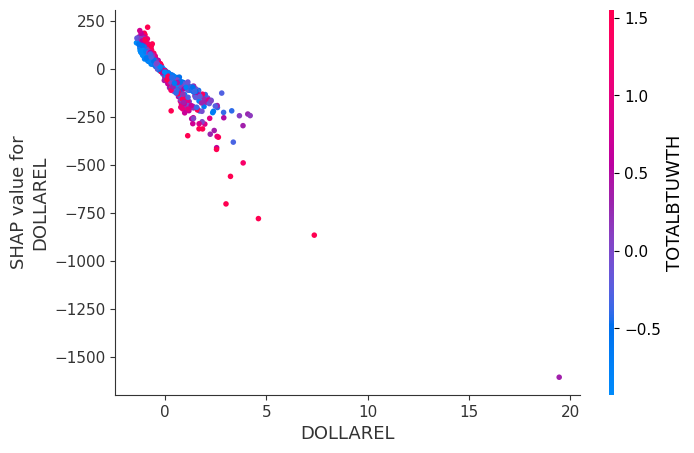

In [98]:
shap.dependence_plot("TOTALDOL", shap_values, X_test, feature_names=X.columns)
shap.dependence_plot("TOTALBTU", shap_values, X_test, feature_names=X.columns)
shap.dependence_plot("DOLLAREL", shap_values, X_test, feature_names=X.columns)

Выбор ряда примеров для explanation plots

In [99]:
sample_indices = [0, 1, 2]

Explanation plots

In [103]:
explainer_2 = shap.KernelExplainer(model.predict, X_train[:10])
shap_values = explainer_2.shap_values(X_test[:10])

1/1 [==============================] - 0s 78ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

640/640 [==============================] - 2s 4ms/step


In [104]:
feature_names = list(X.columns)
shap_values_for_wt = explainer(X_test[:100])

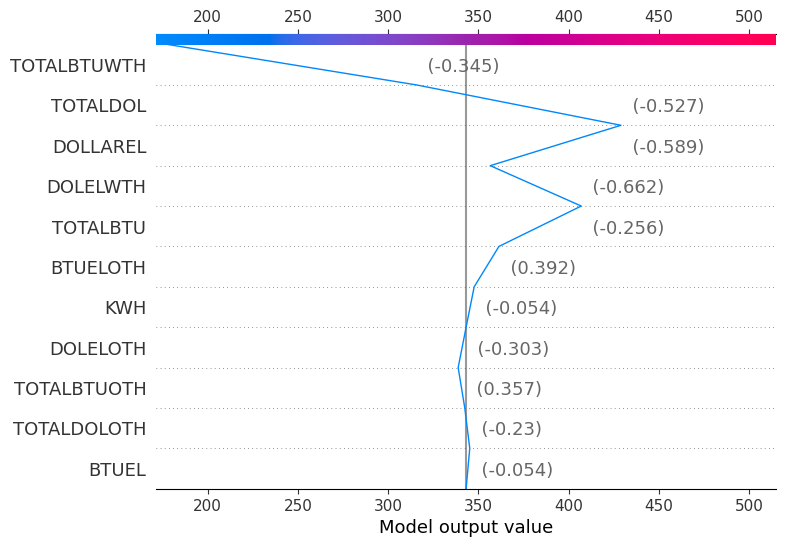

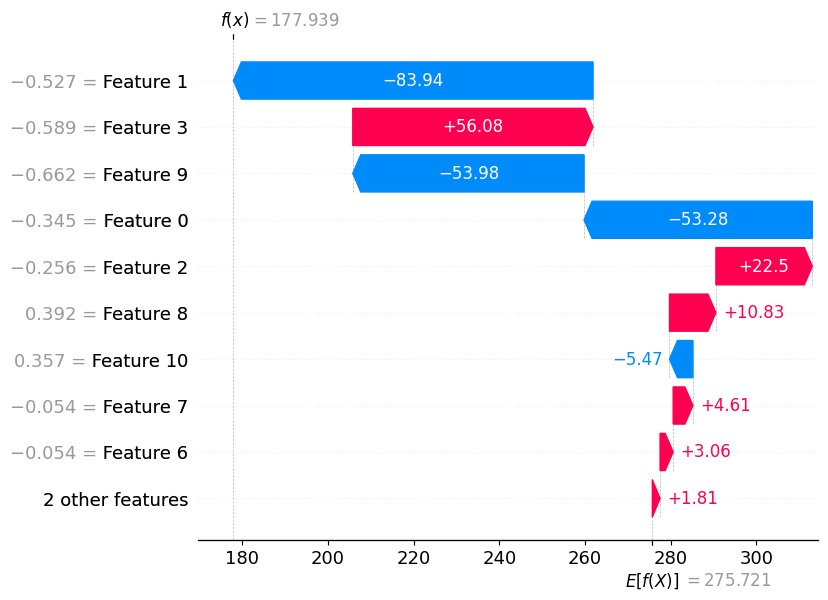

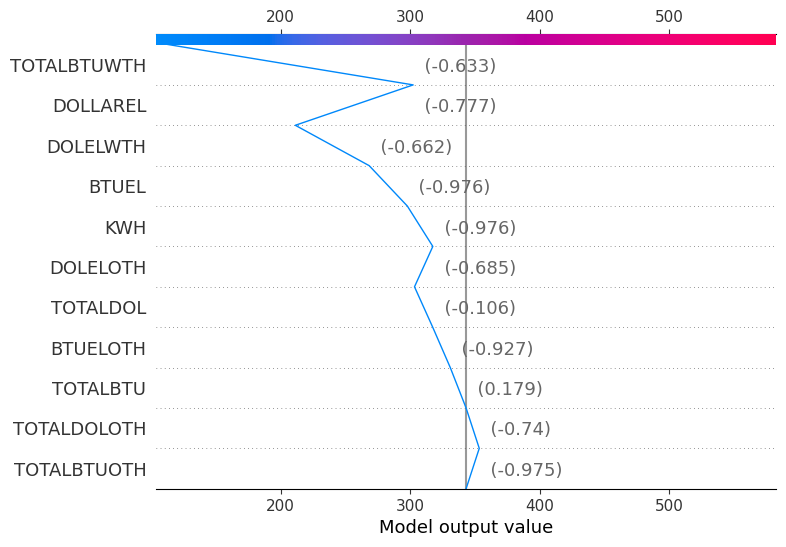

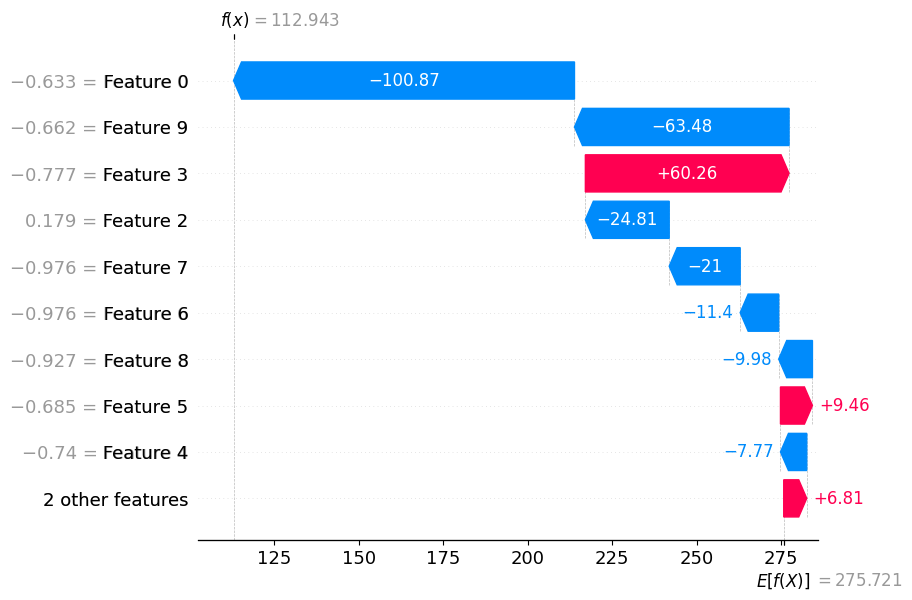

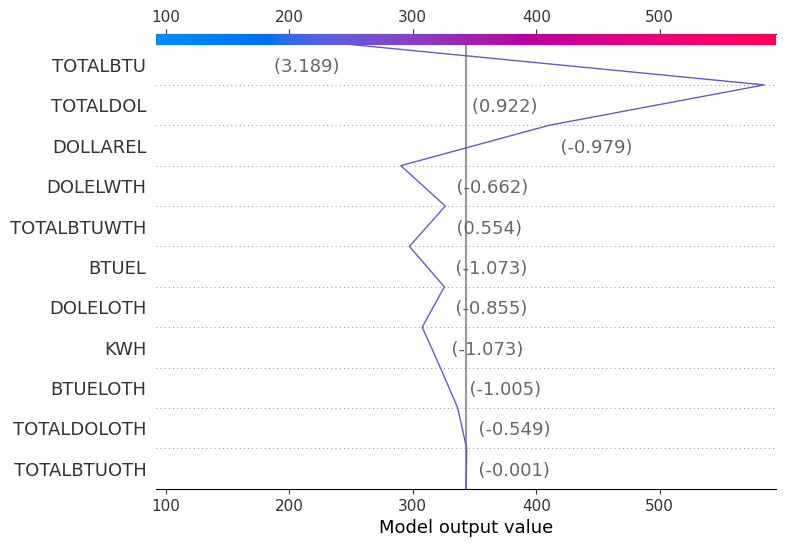

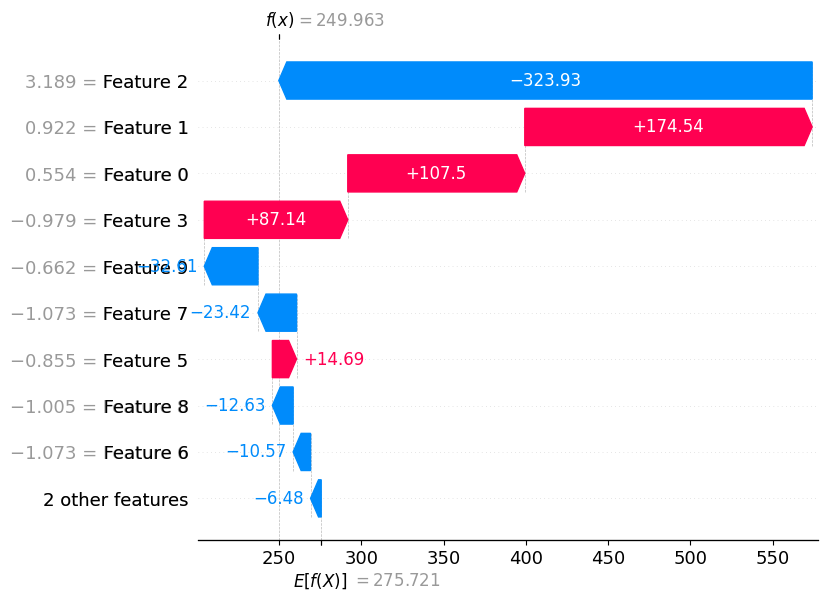

In [105]:
for index in sample_indices:
    shap.decision_plot(explainer_2.expected_value, shap_values[0][index, :], X_test[index, :], feature_names=feature_names)
    shap.force_plot(explainer_2.expected_value, shap_values[0][index, :], X_test[index, :], feature_names=feature_names)
    shap.waterfall_plot(shap_values_for_wt[index])

Построение графиков частичной зависимости

In [106]:
features_of_interest = ["TOTALBTU", "TOTALDOL", "DOLLAREL"]

272/272 [==============================] - 1s 2ms/step


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='TOTALBTU', ylabel='TOTALDOL', zlabel='E[f(x) | TOTALBTU, TOTALDOL]'>)

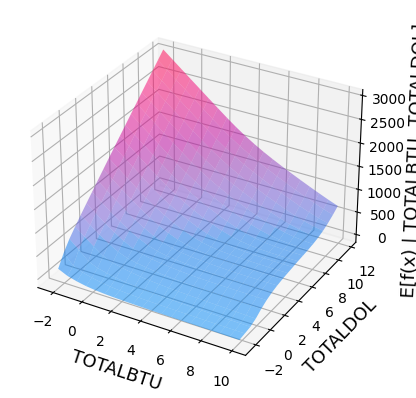

In [107]:
shap.partial_dependence_plot(
    (features_of_interest[0], features_of_interest[1], features_of_interest[2]),
    model.predict,
    X_train,
    feature_names=X.columns,
    ice=False,
    model_expected_value=True,
    show=False
)

272/272 [==============================] - 0s 2ms/step


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='TOTALBTU', ylabel='TOTALDOL', zlabel='E[f(x) | TOTALBTU, TOTALDOL]'>)

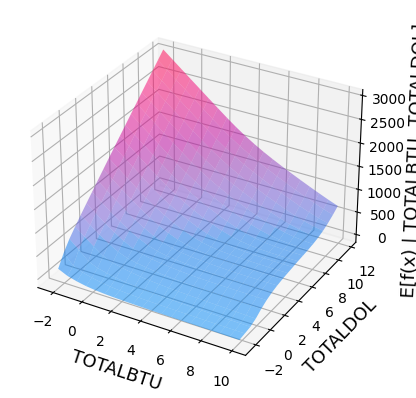

In [109]:
shap.partial_dependence_plot(
    (features_of_interest[0], features_of_interest[1]),
    model.predict,
    X_train,
    feature_names=X.columns,
    ice=True,
    model_expected_value=True,
    show=False
)

##CNN

In [110]:
# Install kaggle
!pip install -q kaggle

In [111]:
# Change directory
import os
os.chdir("/content/drive/MyDrive/masters/Neural_networks/lab_2")

In [112]:
# Create a kaggle folder
!mkdir -p ~/.kaggle

# Copy kaggle.json to created folder
!cp kaggle.json ~/.kaggle/

In [113]:
os.chdir("/content")

In [114]:
# Permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [115]:
# Download the required dataset
!kaggle datasets download -d emmarex/plantdisease

100% 656M/658M [00:05<00:00, 82.3MB/s]
100% 658M/658M [00:05<00:00, 135MB/s] 


In [116]:
# Unzip our dataset
from zipfile import ZipFile
from tqdm import tqdm


file_to_extract = "plantdisease.zip"

# Open your .zip file
with ZipFile(file=file_to_extract) as zip_file:

    # Loop over each file and extract them
    for file in tqdm(iterable=zip_file.namelist(), total=len(zip_file.namelist())):
        zip_file.extract(member=file)

100%|██████████| 41278/41278 [00:21<00:00, 1940.07it/s]


* Класс 0: Tomato_healthy,
* Класс 1: Tomato_Septoria_Leaf_spot

Путь к данным

In [117]:
data_dir = "/content/plantvillage/PlantVillage"

Используем только заданные по условию классы

In [118]:
os.makedirs(os.path.join("/content/binary", "Tomato_healthy"), exist_ok=True)
os.makedirs(os.path.join("/content/binary", "Tomato_Septoria_leaf_spot"), exist_ok=True)

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
import random

In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.optimizers import Adam

In [121]:
source_dir = os.path.join(data_dir, "Tomato_healthy")
for filename in os.listdir(source_dir):
    source_file = os.path.join(source_dir, filename)
    destination_file = os.path.join("/content/binary/Tomato_healthy", filename)
    shutil.copy(source_file, destination_file)

source_dir = os.path.join(data_dir, "Tomato_Septoria_leaf_spot")
for filename in os.listdir(source_dir):
    source_file = os.path.join(source_dir, filename)
    destination_file = os.path.join("/content/binary/Tomato_Septoria_leaf_spot", filename)
    shutil.copy(source_file, destination_file)

Разделим выборку на train, val, test

In [122]:
!pip install split-folders -q

In [123]:
import splitfolders

In [124]:
file_path = "/content/binary"
splitfolders.ratio(file_path, output="./out",
                   seed=333,
                   ratio=(0.6, 0.2, 0.2))

Copying files: 3362 files [00:01, 2930.00 files/s]


Пути к выборкам

In [125]:
train_dir = "/content/out/train"
val_dir = "/content/out/val"
test_dir = "/content/out/test"

### Предобработка изображений

- Создаем объекты ImageDataGenerator, а также масштабируем изображение так, чтобы значения их пикселей были нормализованы между 0 и 1.
-  Загружаем изображения из какалога тестовой и валидационной выборки, размер изменен до 150х150px.
- Размер батча - количество образцов, которые будут распространяться по сети в данный момент времени

In [126]:
tr_gen = ImageDataGenerator(rescale=1/255.0)
v_gen = ImageDataGenerator(rescale=1/255.0)
t_gen = ImageDataGenerator(rescale=1/255.0)

# Load and iterate train dataset
train_ds = tr_gen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        classes=['Tomato_healthy', 'Tomato_Septoria_leaf_spot'],
        shuffle=True,
        seed=42)

# Load and iterate validation dataset
val_ds = v_gen.flow_from_directory(val_dir,
                                   class_mode='binary',
                                   target_size=(150, 150),
                                   batch_size=32,
                                   classes=['Tomato_healthy', 'Tomato_Septoria_leaf_spot'],
                                   shuffle=True,
                                   seed=42)
# Load and iterate test dataset
test_ds = t_gen.flow_from_directory(test_dir,
                                    class_mode='binary',
                                    target_size=(150, 150),
                                    batch_size=32,
                                    classes=['Tomato_healthy', 'Tomato_Septoria_leaf_spot'],
                                    shuffle=True,
                                    seed=42)

Found 2016 images belonging to 2 classes.
Found 672 images belonging to 2 classes.
Found 674 images belonging to 2 classes.


Отобразим несколько изображений для того, чтобы убедиться в верности загрузки данных

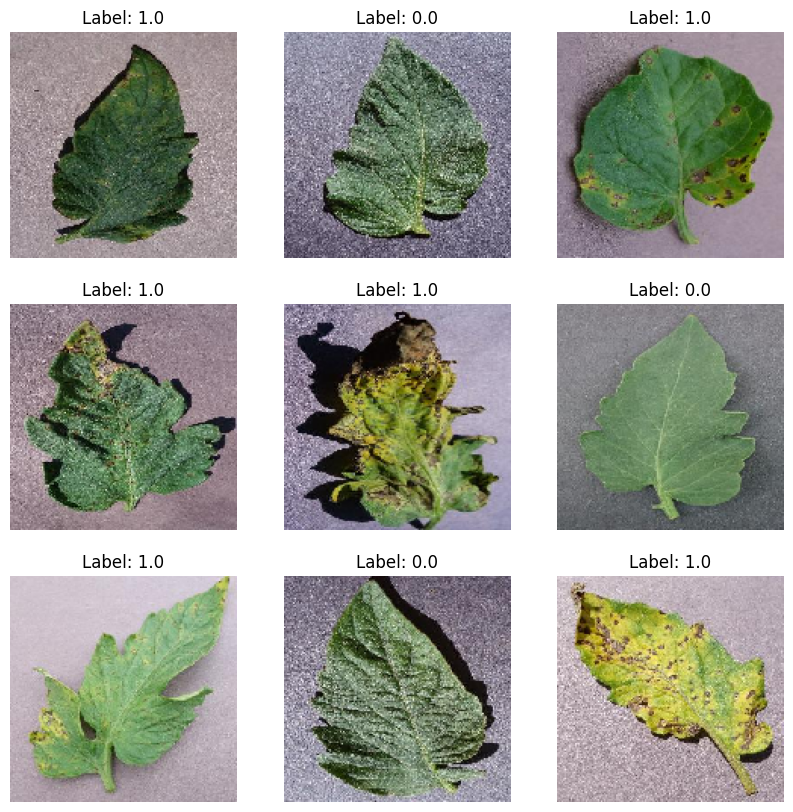

In [127]:
# Load a few images from the test dataset
test_images, test_labels = next(test_ds)

# Display 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Label: {test_labels[i]}")
    plt.axis("off")
plt.show()


### Создадим нейросеть

Начнем с рассмотрения сверточной нейронной сети, т.к. она лучше всего подходит для классификации изображений

#### CNN

In [211]:
model_cnn = Sequential()

model_cnn.add(Conv2D(4, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(8, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(8, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(8, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Flatten())
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

In [212]:
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [213]:
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 4)       112       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 8)         296       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 8)         584       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 8)        

Сохранение наилучшей модели. Если не будет никаких изменений валидационной точности в течении 10 эпох, то остановим обучение

In [214]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [215]:
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5,
                           mode='max',
                           verbose=1
                           )
checkpoint = ModelCheckpoint('binary_cnn_best.hdf5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True
                             )

callbacks_list=[early_stop, checkpoint]

Запустим обучение на 100 эпох с запасом, т.к. модель остановится раньше

In [216]:
epochs = 100
history = model_cnn.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=callbacks_list)

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 0.5862 - accuracy: 0.6687
Epoch 1: val_accuracy improved from -inf to 0.84673, saving model to binary_cnn_best.hdf5
63/63 [==============================] - 6s 71ms/step - loss: 0.5862 - accuracy: 0.6687 - val_loss: 0.3675 - val_accuracy: 0.8467
Epoch 2/100
 1/63 [..............................] - ETA: 5s - loss: 0.3619 - accuracy: 0.8125

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


63/63 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.8814
Epoch 2: val_accuracy improved from 0.84673 to 0.90327, saving model to binary_cnn_best.hdf5
63/63 [==============================] - 5s 75ms/step - loss: 0.2842 - accuracy: 0.8814 - val_loss: 0.2323 - val_accuracy: 0.9033
Epoch 3/100
62/63 [============================>.] - ETA: 0s - loss: 0.1971 - accuracy: 0.9289
Epoch 3: val_accuracy improved from 0.90327 to 0.92708, saving model to binary_cnn_best.hdf5
63/63 [==============================] - 4s 56ms/step - loss: 0.1980 - accuracy: 0.9281 - val_loss: 0.1957 - val_accuracy: 0.9271
Epoch 4/100
62/63 [============================>.] - ETA: 0s - loss: 0.1948 - accuracy: 0.9254
Epoch 4: val_accuracy did not improve from 0.92708
63/63 [==============================] - 4s 58ms/step - loss: 0.1929 - accuracy: 0.9266 - val_loss: 0.1856 - val_accuracy: 0.9271
Epoch 5/100
63/63 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.9340
Epoch

Визуализируем результаты

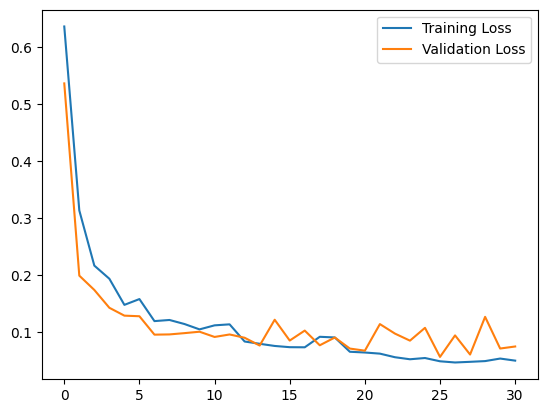

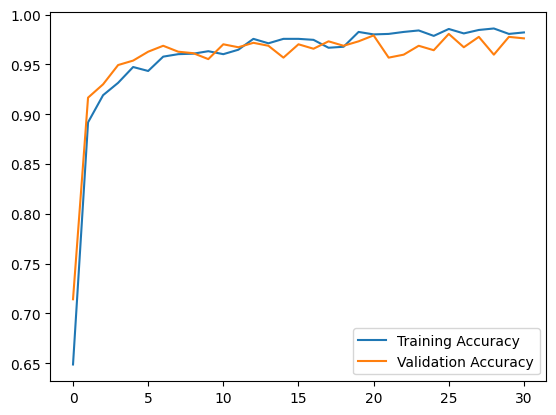

In [134]:
# График функции потерь
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# График точности
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

Загрузим наилучшую модель

In [135]:
model_cnn.load_weights("binary_cnn_best.hdf5")

Делаем предсказание

1/1 [==============================] - 0s 146ms/step


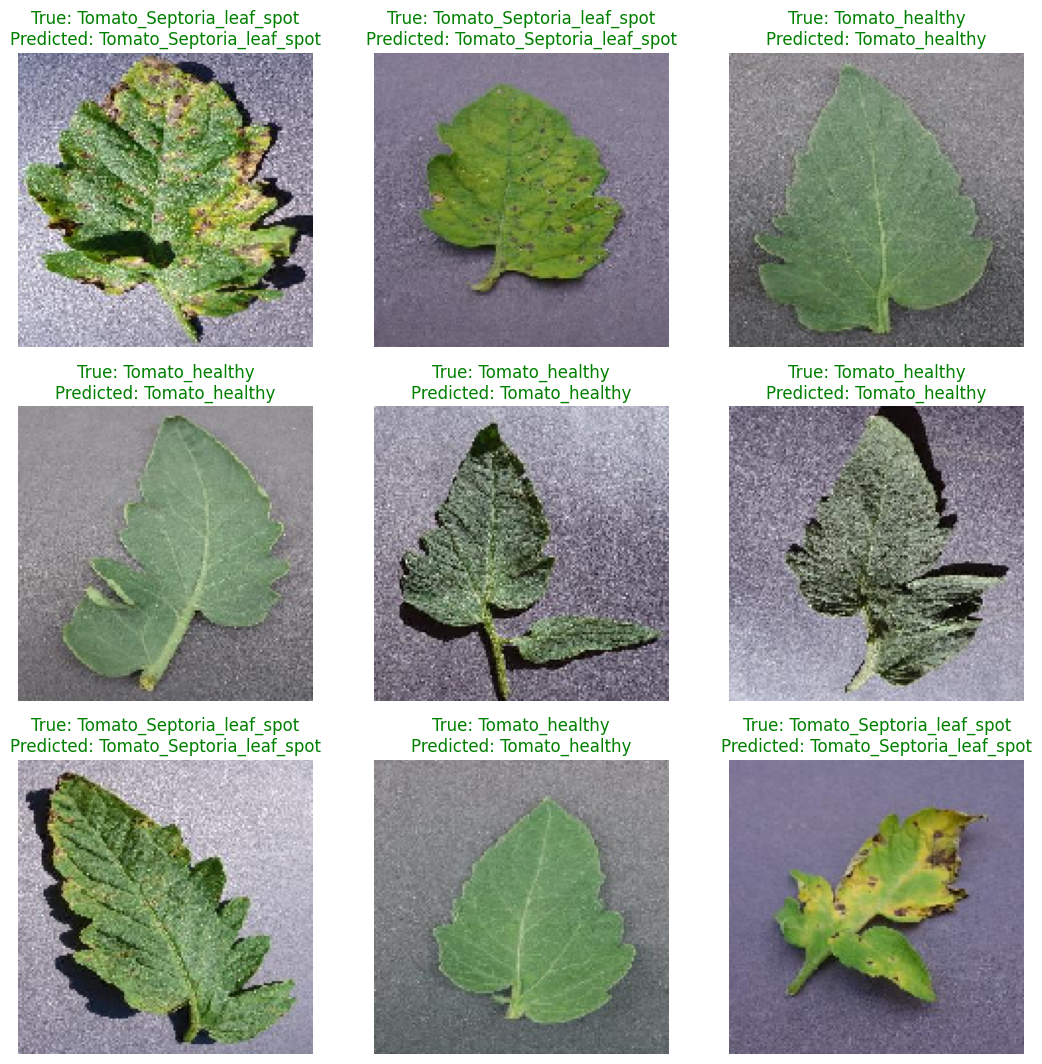

In [138]:
# Получаем изображения и метки из тестового набора
test_images, test_labels = next(test_ds)

# Предсказываем метки для изображений с использованием лучшей модели
predictions = model.predict(test_images)

# Отображаем первые 9 изображений
plt.figure(figsize=(13, 13))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    true_label = 'Tomato_healthy' if test_labels[i] == 0 else 'Tomato_Septoria_leaf_spot'
    predicted_label = 'Tomato_healthy' if predictions[i] < 0.5 else 'Tomato_Septoria_leaf_spot'
    text_color = 'green' if true_label == predicted_label else 'red'
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=text_color)
    plt.axis('off')

plt.show()

### Задания по лабораторной работе

In [220]:
import shap
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

Визуализация промежуточных активаций

In [221]:
# Extract intermediate layer outputs
layer_outputs = [layer.output for layer in model_cnn.layers[:5]]
activation_model = Model(inputs=model_cnn.input, outputs=layer_outputs)

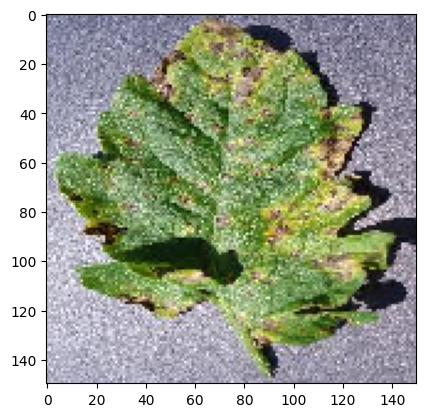

In [222]:
plt.imshow(test_images[0])

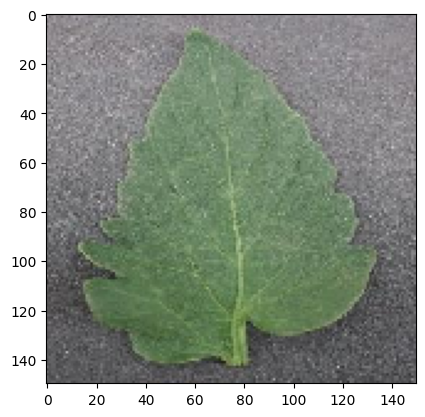

In [223]:
plt.imshow(test_images[2])

In [224]:
# Select an image from the test set
img_1 = test_images[0]
img_2 = test_images[2]

# Reshape the image to (1, 150, 150, 3) to match the input shape of the model
img_1 = np.reshape(img_1, (1,) + img_2.shape)
img_2 = np.reshape(img_2, (1,) + img_2.shape)

# Get the activations for the chosen image
activations_1 = activation_model.predict(img_1)
activations_2 = activation_model.predict(img_2)

1/1 [==============================] - 0s 21ms/step


In [225]:
# Plot the activations
layer_names = [layer.name for layer in model.layers[:5]]

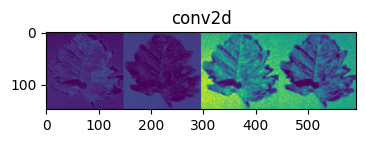

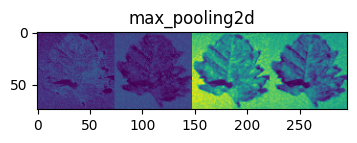

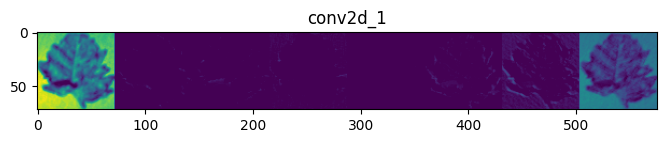

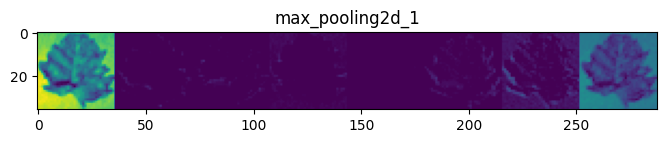

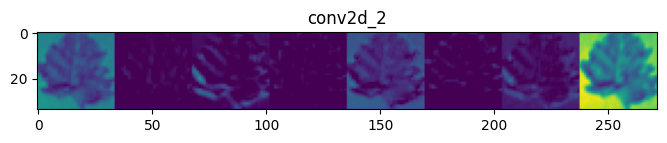

In [226]:
for layer_name, layer_activation in zip(layer_names, activations_1):
    n_features = layer_activation.shape[-1]  # Number of features in the feature map
    size = layer_activation.shape[1]  # The feature map has shape (1, size, size, n_features)

    # Display the feature maps in a grid
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
        channel_image = layer_activation[0, :, :, i]
        display_grid[:, i * size : (i + 1) * size] = channel_image

    scale = 1.0 / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

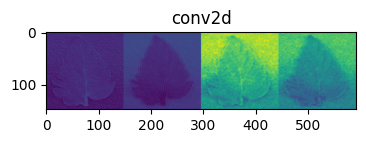

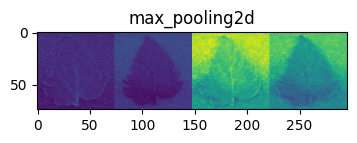

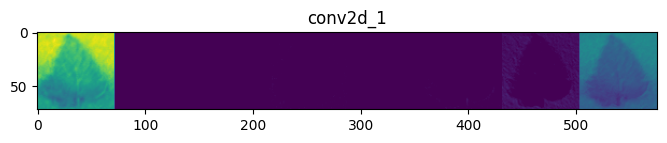

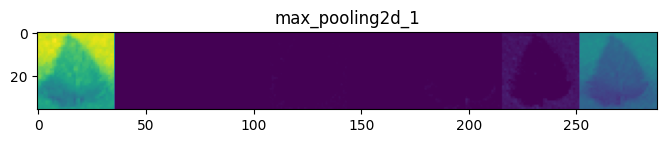

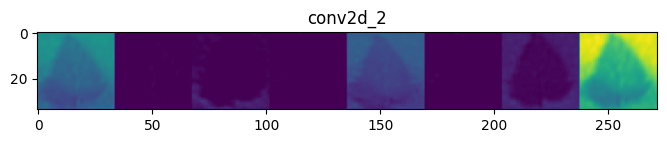

In [227]:
for layer_name, layer_activation in zip(layer_names, activations_2):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]

    # Display the feature maps in a grid
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
        channel_image = layer_activation[0, :, :, i]
        display_grid[:, i * size : (i + 1) * size] = channel_image

    scale = 1.0 / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

Визуализация фильтров сверточной нейронной сети

In [228]:
# Извлечение весов с 1-го сверточного слоя
filters, biases = model.layers[0].get_weights()

In [229]:
# Нормализуем значения фильтров [0, 1]
filters_min, filters_max = filters.min(), filters.max()
filters = (filters - filters_min) / (filters_max - filters_min)

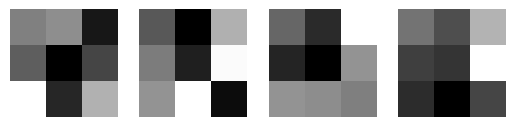

In [230]:
# Визуализируем
n_filters = filters.shape[3]
filter_size = filters.shape[0]

for i in range(n_filters):
    plt.subplot(1, n_filters, i + 1)
    plt.imshow(filters[:, :, 0, i], cmap='gray')
    plt.axis('off')

plt.show()

Grad-CAM (Gradient-weighted Class Activation Mapping):

In [231]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

  # Сначала мы создаем модель, которая сопоставляет входное изображение с
  # активациями последнего конвентного слоя, а также выходным предсказаниям
  grad_model = tf.keras.models.Model(
      [model_cnn.inputs], [model_cnn.get_layer(last_conv_layer_name).output, model_cnn.output]
  )

  # Затем мы вычисляем градиент верхнего предсказанного класса для нашего
  # входного изображения относительно активаций последнего слоя conv
  with tf.GradientTape() as tape:
      last_conv_layer_output, preds = grad_model(img_array)
      if pred_index is None:
          pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

  # Это градиент выходного нейрона (верхнего предсказанного или выбранного)
  #по отношению к выходной карте признаков последнего слоя conv
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # Это вектор, каждая запись которого представляет собой среднюю интенсивность
  # градиента по определенному каналу карты характеристик
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # Мы умножаем каждый канал в массиве карты признаков на "степень важности
  #этого канала" по отношению к верхнему предсказанному классу, затем суммируем
  #все каналы, чтобы получить тепловую карту активации класса.
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # Абсолютное значение градиента показывает эффект изменения в каждом пикселе
  heatmap = tf.abs(heatmap)

  # Normalize to between 0 and 1
  heatmap_min = np.min(heatmap)
  heatmap_max = np.max(heatmap)
  heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min + tf.keras.backend.epsilon())

  return heatmap.numpy()

In [232]:
for layer in model_cnn.layers:
    print(layer, layer.name)

last_conv_layer = None
for layer in reversed(model_cnn.layers):
    if 'conv2d' in layer.name:
        last_conv_layer = layer.name
        break

if last_conv_layer is not None:
    print("Last convolution layer found:", last_conv_layer)
else:
    print("Nothing found")

<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f30a9b38fa0> conv2d_4
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f30a9a9f400> max_pooling2d_4
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f30a9b651e0> conv2d_5
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f30a9ab6920> max_pooling2d_5
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f30a9ab6980> conv2d_6
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f30a9ab4c70> max_pooling2d_6
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f30a9ab7160> conv2d_7
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f30a9ab7370> max_pooling2d_7
<keras.src.layers.reshaping.flatten.Flatten object at 0x7f311d41fbe0> flatten_1
<keras.src.layers.core.dense.Dense object at 0x7f30a9ab5630> dense_8
<keras.src.layers.core.dense.Dense object at 0x7f30a9ad9060> dense_9
Last convolution layer found: conv2d_7


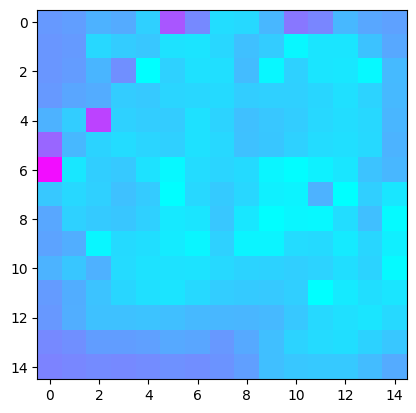

In [233]:
heatmap = make_gradcam_heatmap(img_1, model_cnn, last_conv_layer)
plt.imshow(heatmap, cmap='cool', vmin=0.0, vmax=1.0)

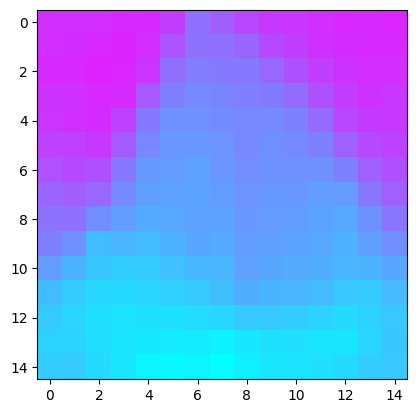

In [234]:
heatmap = make_gradcam_heatmap(img_2, model_cnn, last_conv_layer)
plt.imshow(heatmap, cmap='cool', vmin=0.0, vmax=1.0)

Тепловые карты активации классов с помощью значений Шепли

In [237]:
def shap_heatmap(model, img_tensor):
    explainer = shap.DeepExplainer(model, img_tensor)
    shap_values = explainer.shap_values(img_tensor)

    # Визуализация первой карты значений SHAP
    shap.image_plot(shap_values, img_tensor)
    plt.show()
    # print(shap_values)

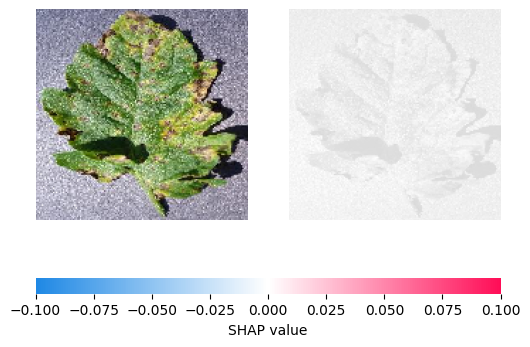

In [238]:
# Call the shap_heatmap function
shap_heatmap(model_cnn, img_1)

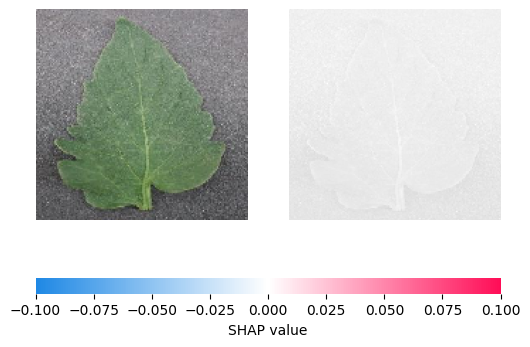

In [240]:
shap_heatmap(model_cnn, img_2)